<a href="https://colab.research.google.com/github/juanesRodriguez23/ANTLR/blob/main/parcial%20%232.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www.antlr.org/download/antlr-4.13.1-complete.jar
!java -jar antlr-4.13.1-complete.jar CRUDLang.g4


--2025-10-16 01:39:38--  https://www.antlr.org/download/antlr-4.13.1-complete.jar
Resolving www.antlr.org (www.antlr.org)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to www.antlr.org (www.antlr.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2139203 (2.0M) [application/java-archive]
Saving to: ‘antlr-4.13.1-complete.jar.5’

antlr-4.13.1-comple 100%[===================>]   2.04M  10.4MB/s    in 0.2s    

2025-10-16 01:39:39 (10.4 MB/s) - ‘antlr-4.13.1-complete.jar.5’ saved [2139203/2139203]



In [ ]:
%%writefile CRUDLang.g4
grammar CRUDLang;

////////////////////////////////////////////////////////////
// GRAMÁTICA PRINCIPAL DEL LENGUAJE CRUD
////////////////////////////////////////////////////////////

// Regla de inicio: un programa contiene una o más sentencias
prog: stmt+ ;

////////////////////////////////////////////////////////////
// Tipos de sentencias CRUD
////////////////////////////////////////////////////////////

// Cada sentencia puede ser CREATE, SELECT, UPDATE o DELETE
stmt
    : createStmt
    | selectStmt
    | updateStmt
    | deleteStmt
    ;

////////////////////////////////////////////////////////////
// SENTENCIA CREATE
////////////////////////////////////////////////////////////

// CREATE TABLE empleados (id INT, nombre STRING);
createStmt
    : 'CREATE' 'TABLE' ID '(' columnDef (',' columnDef)* ')' ';'
    ;

// Definición de columnas dentro del CREATE
columnDef
    : ID type
    ;

// Tipos de datos soportados
type
    : 'INT'
    | 'FLOAT'
    | 'STRING'
    ;

////////////////////////////////////////////////////////////
// SENTENCIA SELECT
////////////////////////////////////////////////////////////

// SELECT nombre, salario FROM empleados WHERE salario > 1000;
selectStmt
    : 'SELECT' columnList 'FROM' ID ('WHERE' condition)? ';'
    ;

// Lista de columnas seleccionadas
columnList
    : ID (',' ID)*
    ;

////////////////////////////////////////////////////////////
// SENTENCIA UPDATE
////////////////////////////////////////////////////////////

// UPDATE empleados SET salario = 3000 WHERE id = 2;
updateStmt
    : 'UPDATE' ID 'SET' assignment ('WHERE' condition)? ';'
    ;

// Asignación de valores (columna = valor)
assignment
    : ID '=' value
    ;

////////////////////////////////////////////////////////////
// SENTENCIA DELETE
////////////////////////////////////////////////////////////

// DELETE FROM empleados WHERE id = 2;
deleteStmt
    : 'DELETE' 'FROM' ID ('WHERE' condition)? ';'
    ;

////////////////////////////////////////////////////////////
// CONDICIONES Y EXPRESIONES
////////////////////////////////////////////////////////////

// Condición simple tipo: columna = valor
condition
    : ID comparator value
    ;

// Comparadores permitidos
comparator
    : '=' | '>' | '<'
    ;

// Valores que pueden ser usados en condiciones o asignaciones
value
    : STRING_LITERAL | NUMBER
    ;

////////////////////////////////////////////////////////////
// TOKENS Y REGLAS LÉXICAS
////////////////////////////////////////////////////////////

// Identificadores: nombres de tablas o columnas
ID: [a-zA-Z_][a-zA-Z0-9_]* ;

// Números enteros o flotantes
NUMBER: [0-9]+ ('.' [0-9]+)? ;

// Cadenas de texto entre comillas simples
STRING_LITERAL: '\'' (~['\\] | '\\' .)* '\'' ;

// Ignorar espacios, tabulaciones y saltos de línea
WS: [ \t\r\n]+ -> skip ;



Overwriting CRUDLang.g4


In [ ]:
# ==========================================
# LÉXICO CRUD: Analizador de Tokens
# ==========================================

# Este bloque define un analizador léxico (lexer) que:
# 1. Usa expresiones regulares para reconocer palabras clave (CREATE, SELECT, etc.).
# 2. Divide una sentencia SQL en sus componentes básicos llamados "tokens".
# 3. Ignora espacios y caracteres inválidos.
# 4. Muestra el resultado de la tokenización para sentencias CRUD.

import re

# --------------------------------------------------
# Definición de tokens (palabras clave, símbolos, etc.)
# --------------------------------------------------
TOKEN_SPECIFICATION = [
    ("CREATE",      r"CREATE\b"),          # palabra clave CREATE
    ("TABLE",       r"TABLE\b"),           # palabra clave TABLE
    ("SELECT",      r"SELECT\b"),          # palabra clave SELECT
    ("FROM",        r"FROM\b"),            # palabra clave FROM
    ("WHERE",       r"WHERE\b"),           # palabra clave WHERE
    ("UPDATE",      r"UPDATE\b"),          # palabra clave UPDATE
    ("SET",         r"SET\b"),             # palabra clave SET
    ("DELETE",      r"DELETE\b"),          # palabra clave DELETE
    ("INT",         r"INT\b"),             # tipo de dato INT
    ("STRING",      r"STRING\b"),          # tipo de dato STRING
    ("FLOAT",       r"FLOAT\b"),           # tipo de dato FLOAT
    ("BOOL",        r"BOOL\b"),            # tipo de dato BOOL
    ("VALUES",      r"VALUES\b"),          # palabra clave VALUES
    ("AND",         r"AND\b"),             # operador lógico AND
    ("OR",          r"OR\b"),              # operador lógico OR
    ("COMPARATOR",  r"<=|>=|!=|=|<|>"),    # comparadores relacionales
    ("LPAREN",      r"\("),                # paréntesis izquierdo
    ("RPAREN",      r"\)"),                # paréntesis derecho
    ("COMMA",       r","),                 # coma
    ("SEMICOLON",   r";"),                 # punto y coma
    ("STRING_LITERAL", r"'[^']*'"),        # cadenas entre comillas simples
    ("NUMBER",      r"\d+"),               # números
    ("IDENTIFIER",  r"[A-Za-z_][A-Za-z0-9_]*"),  # nombres de variables o tablas
    ("SKIP",        r"[ \t\n]+"),          # espacios y tabulaciones
    ("MISMATCH",    r"."),                 # cualquier otro carácter
]

# --------------------------------------------------
# Compilación del patrón de expresiones regulares
# --------------------------------------------------
TOK_REGEX = "|".join(f"(?P<{name}>{pattern})" for name, pattern in TOKEN_SPECIFICATION)
token_pattern = re.compile(TOK_REGEX)

# --------------------------------------------------
# Función del lexer: genera una lista de tokens
# --------------------------------------------------
def lexer(code):
    tokens = []
    for match in token_pattern.finditer(code):
        kind = match.lastgroup
        value = match.group()

        if kind == "SKIP":
            continue  # se ignoran espacios y saltos de línea
        elif kind == "MISMATCH":
            raise RuntimeError(f"Token inválido: {value}")  # error si no se reconoce el token

        tokens.append((kind, value))
    return tokens

# --------------------------------------------------
# Pruebas del lexer con ejemplos CRUD
# --------------------------------------------------
examples = [
    "CREATE TABLE empleados (id INT, nombre STRING, salario FLOAT);",
    "SELECT nombre, salario FROM empleados WHERE nombre = 'Juan';",
    "UPDATE empleados SET salario = 3200 WHERE nombre = 'Juan';",
    "DELETE FROM empleados WHERE nombre = 'Juan';"
]

# --------------------------------------------------
# Ejecución y muestra de resultados
# --------------------------------------------------
for ex in examples:
    print(f"\nEntrada: {ex}")
    print("Tokens:", lexer(ex))



Entrada: CREATE TABLE empleados (id INT, nombre STRING, salario FLOAT);
Tokens: [('CREATE', 'CREATE'), ('TABLE', 'TABLE'), ('IDENTIFIER', 'empleados'), ('LPAREN', '('), ('IDENTIFIER', 'id'), ('INT', 'INT'), ('COMMA', ','), ('IDENTIFIER', 'nombre'), ('STRING', 'STRING'), ('COMMA', ','), ('IDENTIFIER', 'salario'), ('FLOAT', 'FLOAT'), ('RPAREN', ')'), ('SEMICOLON', ';')]

Entrada: SELECT nombre, salario FROM empleados WHERE nombre = 'Juan';
Tokens: [('SELECT', 'SELECT'), ('IDENTIFIER', 'nombre'), ('COMMA', ','), ('IDENTIFIER', 'salario'), ('FROM', 'FROM'), ('IDENTIFIER', 'empleados'), ('WHERE', 'WHERE'), ('IDENTIFIER', 'nombre'), ('COMPARATOR', '='), ('STRING_LITERAL', "'Juan'"), ('SEMICOLON', ';')]

Entrada: UPDATE empleados SET salario = 3200 WHERE nombre = 'Juan';
Tokens: [('UPDATE', 'UPDATE'), ('IDENTIFIER', 'empleados'), ('SET', 'SET'), ('IDENTIFIER', 'salario'), ('COMPARATOR', '='), ('NUMBER', '3200'), ('WHERE', 'WHERE'), ('IDENTIFIER', 'nombre'), ('COMPARATOR', '='), ('STRING_LITE

Punto 2 ( antlr )

In [ ]:
!apt-get install openjdk-11-jdk -qq
!wget -q https://www.antlr.org/download/antlr-4.13.1-complete.jar
!export CLASSPATH=".:/content/antlr-4.13.1-complete.jar:$CLASSPATH"
!alias antlr4='java -jar /content/antlr-4.13.1-complete.jar'
!alias grun='java org.antlr.v4.gui.TestRig'


In [ ]:
!java -jar /content/antlr-4.13.1-complete.jar -Dlanguage=Python3 CRUDLang.g4 -visitor -no-listener


In [ ]:
# =============================================================================
# CELDA: Paso 2 - Implementación del parser CRUD con ANTLR (versión para Colab)
# Resumen breve: esta celda crea la gramática ANTLR, instala el runtime,
# descarga ANTLR, genera los archivos Python del lexer/parser y prueba
# varias sentencias CRUD mostrando el árbol sintáctico.
# =============================================================================

# -----------------------------------------
# 1) Crear el archivo CRUDLang.g4 (gramática)
# Qué hace: escribe en disco una gramática ANTLR simplificada y segura
#            que acepta sentencias CREATE, SELECT, UPDATE y DELETE.
# -----------------------------------------
crud_grammar_lines_safe = [
    "grammar CRUDLang;",
    "",
    "// Regla principal: programa compuesto por 0 o más sentencias",
    "program : statement* EOF ;",
    "",
    "// Lista de sentencias: CREATE, READ, UPDATE, DELETE",
    "statement : create_stmt",
    "          | read_stmt",
    "          | update_stmt",
    "          | delete_stmt ;",
    "",
    "// CREATE TABLE simple (identificador de columnas separado por comas)",
    "create_stmt : 'CREATE' 'TABLE' IDENTIFIER '(' IDENTIFIER (',' IDENTIFIER)* ')' ';' ;",
    "",
    "// SELECT simple: columnas, FROM, tabla, opcional WHERE con comparación por '='",
    "read_stmt : 'SELECT' IDENTIFIER (',' IDENTIFIER)* 'FROM' IDENTIFIER ('WHERE' IDENTIFIER '=' NUMBER)? ';' ;",
    "",
    "// UPDATE simple: UPDATE tabla SET columna = número [, WHERE ...]",
    "update_stmt : 'UPDATE' IDENTIFIER 'SET' IDENTIFIER '=' NUMBER ('WHERE' IDENTIFIER '=' NUMBER)? ';' ;",
    "",
    "// DELETE simple: DELETE FROM tabla [, WHERE ...]",
    "delete_stmt : 'DELETE' 'FROM' IDENTIFIER ('WHERE' IDENTIFIER '=' NUMBER)? ';' ;",
    "",
    "// Definición de tokens básicos",
    "IDENTIFIER : [a-zA-Z_][a-zA-Z0-9_]* ;",
    "NUMBER : [0-9]+ ;",
    "WS : [ \\t\\r\\n]+ -> skip ;"
]

with open("CRUDLang.g4", "w", newline='\n') as f:
    for line in crud_grammar_lines_safe:
        f.write(line + "\n")

print("Archivo CRUDLang.g4 creado (gramática ANTLR simplificada).")

# -----------------------------------------
# 2) Instalar runtime de ANTLR compatible con Python
# Qué hace: instala la versión del runtime Python que es compatible con
#            la versión de ANTLR/Colab que usaremos.
# Nota: si ya está instalada, pip la ignorará; puede mostrar advertencias sobre dependencias.
# -----------------------------------------
!pip install -q antlr4-python3-runtime==4.13.2

# -----------------------------------------
# 3) Descargar el jar de ANTLR (si no está)
# Qué hace: descarga el ejecutable de ANTLR para poder generar código desde la gramática.
# -----------------------------------------
!wget -q https://www.antlr.org/download/antlr-4.13.1-complete.jar

# -----------------------------------------
# 4) Generar lexer y parser en Python
# Qué hace: invoca ANTLR para generar los módulos Python a partir del .g4.
#           Usamos la opción -visitor y -no-listener por si queremos implementar visitors.
# -----------------------------------------
!java -jar antlr-4.13.1-complete.jar -Dlanguage=Python3 CRUDLang.g4 -visitor -no-listener

# -----------------------------------------
# 5) Probar el parser con sentencias de ejemplo
# Qué hace: crea un stream de entrada para cada ejemplo, tokeniza con el lexer
#           generado, parsea con el parser generado y muestra el árbol sintáctico.
# -----------------------------------------
from antlr4 import *
from CRUDLangLexer import CRUDLangLexer
from CRUDLangParser import CRUDLangParser

examples = [
    "CREATE TABLE empleados (id,nombre,salario);",
    "SELECT nombre,salario FROM empleados WHERE salario=2000;",
    "UPDATE empleados SET salario=2500 WHERE id=3;",
    "DELETE FROM empleados WHERE id=3;"
]

for ex in examples:
    print("\n--- Analizando: {}".format(ex))
    lexer = CRUDLangLexer(InputStream(ex))
    tokens = CommonTokenStream(lexer)
    parser = CRUDLangParser(tokens)

    # Parsear desde la regla principal 'program'
    tree = parser.program()

    # Mostrar el árbol sintáctico en forma de texto (fácil de leer)
    print(tree.toStringTree(recog=parser))



Archivo CRUDLang.g4 creado (gramática ANTLR simplificada).

--- Analizando: CREATE TABLE empleados (id,nombre,salario);
(program (statement (create_stmt CREATE TABLE empleados ( id , nombre , salario ) ;)) <EOF>)

--- Analizando: SELECT nombre,salario FROM empleados WHERE salario=2000;
(program (statement (read_stmt SELECT nombre , salario FROM empleados WHERE salario = 2000 ;)) <EOF>)

--- Analizando: UPDATE empleados SET salario=2500 WHERE id=3;
(program (statement (update_stmt UPDATE empleados SET salario = 2500 WHERE id = 3 ;)) <EOF>)

--- Analizando: DELETE FROM empleados WHERE id=3;
(program (statement (delete_stmt DELETE FROM empleados WHERE id = 3 ;)) <EOF>)


Punto 3

In [ ]:
# === Punto 3: Analizador sintáctico ascendente ===

# Gramática original:
#   E -> E + T | T
#   T -> T * F | F
#   F -> (E) | id
#
# Esta gramática es recursiva por la izquierda, por tanto NO es LL(1).
# La transformamos eliminando la recursión izquierda.

# Gramática transformada (forma LL(1)):
#   E  -> T E'
#   E' -> + T E' | ε
#   T  -> F T'
#   T' -> * F T' | ε
#   F  -> ( E ) | id


In [ ]:
# === Cálculo de FIRST, FOLLOW y conjuntos de predicción ===

# -----------------------------------------------------------
# Definición de la gramática transformada (forma LL(1))
# -----------------------------------------------------------
# E  -> T E'
# E' -> + T E' | ε
# T  -> F T'
# T' -> * F T' | ε
# F  -> ( E ) | id
# -----------------------------------------------------------

grammar = {
    "E": [["T", "E'"]],
    "E'":[["+", "T", "E'"], []],  # [] representa ε
    "T": [["F", "T'"]],
    "T'":[["*", "F", "T'"], []],
    "F": [["(", "E", ")"], ["id"]]
}

# No terminales y terminales
nonterminals = list(grammar.keys())
terminals = set(["+", "*", "(", ")", "id", "$"])

# -----------------------------------------------------------
# Cálculo del conjunto FIRST
# -----------------------------------------------------------
# FIRST(X) = conjunto de terminales que pueden aparecer
# al inicio de una derivación desde X.

FIRST = {nt: set() for nt in nonterminals}
changed = True
while changed:
    changed = False
    for A in nonterminals:
        for prod in grammar[A]:
            if len(prod) == 0:  # ε-producción
                if "" not in FIRST[A]:
                    FIRST[A].add("")
                    changed = True
            else:
                add_epsilon = True
                for X in prod:
                    # Si es terminal, se agrega directamente
                    if X in terminals:
                        if X not in FIRST[A]:
                            FIRST[A].add(X)
                            changed = True
                        add_epsilon = False
                        break
                    # Si es no terminal, se propagan sus FIRST
                    else:
                        before = len(FIRST[A])
                        FIRST[A].update(x for x in FIRST[X] if x != "")
                        if len(FIRST[A]) != before:
                            changed = True
                        # Si tiene ε, continuar con el siguiente símbolo
                        if "" in FIRST[X]:
                            add_epsilon = True
                            continue
                        else:
                            add_epsilon = False
                            break
                # Si todos los símbolos derivan ε, agregar ε
                if add_epsilon:
                    if "" not in FIRST[A]:
                        FIRST[A].add("")
                        changed = True

# -----------------------------------------------------------
# Cálculo del conjunto FOLLOW
# -----------------------------------------------------------
# FOLLOW(X) = conjunto de terminales que pueden aparecer
# justo después de X en alguna derivación.

FOLLOW = {nt: set() for nt in nonterminals}
FOLLOW["E"].add("$")  # El símbolo inicial siempre contiene '$'

changed = True
while changed:
    changed = False
    for A in nonterminals:
        for prod in grammar[A]:
            for i, B in enumerate(prod):
                if B in nonterminals:
                    beta = prod[i+1:]  # Símbolos que siguen a B
                    if len(beta)==0:
                        # Si B está al final, FOLLOW(B) incluye FOLLOW(A)
                        before = len(FOLLOW[B])
                        FOLLOW[B].update(FOLLOW[A])
                        if len(FOLLOW[B]) != before:
                            changed = True
                    else:
                        # Calcular FIRST(beta)
                        first_beta = set()
                        add_followA = True
                        for symbol in beta:
                            if symbol in terminals:
                                first_beta.add(symbol)
                                add_followA = False
                                break
                            else:
                                first_beta.update(x for x in FIRST[symbol] if x != "")
                                if "" in FIRST[symbol]:
                                    add_followA = True
                                    continue
                                else:
                                    add_followA = False
                                    break
                        # Agregar FIRST(beta) a FOLLOW(B)
                        before = len(FOLLOW[B])
                        FOLLOW[B].update(first_beta)
                        if len(FOLLOW[B]) != before:
                            changed = True
                        # Si beta puede derivar ε, agregar FOLLOW(A)
                        if add_followA:
                            before = len(FOLLOW[B])
                            FOLLOW[B].update(FOLLOW[A])
                            if len(FOLLOW[B]) != before:
                                changed = True

# -----------------------------------------------------------
# Cálculo de los conjuntos de PREDICCIÓN
# -----------------------------------------------------------
# PRED(A -> α) = FIRST(α)
# Si α ⇒* ε, entonces agregar FOLLOW(A)

prediction = {}
for A in nonterminals:
    prediction[A] = []
    for prod in grammar[A]:
        first_alpha = set()
        if len(prod)==0:
            first_alpha.add("")
        else:
            add_eps = True
            for sym in prod:
                if sym in terminals:
                    first_alpha.add(sym)
                    add_eps = False
                    break
                else:
                    first_alpha.update(x for x in FIRST[sym] if x != "")
                    if "" in FIRST[sym]:
                        add_eps = True
                        continue
                    else:
                        add_eps = False
                        break
            if add_eps:
                first_alpha.add("")
        pred = set(x for x in first_alpha if x != "")
        if "" in first_alpha:
            pred.update(FOLLOW[A])
        prediction[A].append((prod, pred))

# -----------------------------------------------------------
# Resultados: FIRST, FOLLOW y conjuntos de PREDICCIÓN
# -----------------------------------------------------------

print("FIRST:")
for k in FIRST:
    print(f" {k} : {FIRST[k]}")

print("\nFOLLOW:")
for k in FOLLOW:
    print(f" {k} : {FOLLOW[k]}")

print("\nPREDICTION SETS:")
for A in prediction:
    for prod, pred in prediction[A]:
        rhs = ' '.join(prod) if prod else 'ε'
        print(f" {A} -> {rhs}  =>  {pred}")



FIRST:
 E : {'id', '('}
 E' : {'', '+'}
 T : {'id', '('}
 T' : {'', '*'}
 F : {'id', '('}

FOLLOW:
 E : {'$', ')'}
 E' : {'$', ')'}
 T : {')', '$', '+'}
 T' : {')', '$', '+'}
 F : {'*', ')', '$', '+'}

PREDICTION SETS:
 E -> T E'  =>  {'id', '('}
 E' -> + T E'  =>  {'+'}
 E' -> ε  =>  {'$', ')'}
 T -> F T'  =>  {'id', '('}
 T' -> * F T'  =>  {'*'}
 T' -> ε  =>  {'$', ')', '+'}
 F -> ( E )  =>  {'('}
 F -> id  =>  {'id'}


In [ ]:
# === Analizador sintáctico ascendente (shift-reduce) ===
# Este código implementa un analizador sintáctico tipo Shift-Reduce
# para la gramática transformada del lenguaje aritmético básico.
# Se apoya en una pila y un buffer de entrada, aplicando reducciones
# conforme a las producciones válidas de la gramática.

# --- Generar lista de producciones (A -> α) ---
productions = []
for A in grammar:
    for prod in grammar[A]:
        productions.append((A, prod))  # Guardamos cada producción como una tupla (NoTerminal, [Símbolos])

# --- Intentar reducir la pila ---
def try_reduce(stack):
    # Recorre todas las producciones y verifica si el tope de la pila coincide con el lado derecho de alguna.
    for A, prod in productions:
        if len(prod) == 0:
            continue  # Ignora producciones vacías (ε)
        # Verifica si los últimos elementos de la pila coinciden con la producción
        if len(stack) >= len(prod) and stack[-len(prod):] == prod:
            # Si hay coincidencia, realiza la reducción
            for _ in range(len(prod)):
                stack.pop()  # Elimina la parte derecha de la pila
            stack.append(A)  # Sustituye por el no terminal correspondiente
            return True, f"Reduce: {A} -> {' '.join(prod)}"
    # Si no hay reducción posible
    return False, None

# --- Algoritmo principal de análisis shift-reduce ---
def shift_reduce_parse(tokens):
    stack = ["$"]  # Inicializa la pila con el símbolo de fin de entrada
    input_buf = tokens.copy()  # Copia de la lista de tokens de entrada
    actions = []  # Guarda las acciones realizadas para mostrar trazas

    while True:
        # Intentar reducir tantas veces como sea posible antes de hacer un shift
        reduced = True
        while reduced:
            reduced, msg = try_reduce(stack)
            if reduced:
                actions.append((stack.copy(), input_buf.copy(), msg))

        # Si aún hay tokens por procesar, aplicar "Shift"
        if len(input_buf) > 0:
            tok = input_buf.pop(0)
            stack.append(tok)
            actions.append((stack.copy(), input_buf.copy(), f"Shift '{tok}'"))

            # Condición de aceptación: pila contiene E y la entrada solo tiene $
            if stack == ["$", "E"] and input_buf == ['$']:
                actions.append((stack.copy(), input_buf.copy(), "ACCEPT"))
                return True, actions
            continue

        # Si no quedan tokens, intentar reducir lo que queda
        else:
            reduced = True
            while reduced:
                reduced, msg = try_reduce(stack)
                if reduced:
                    actions.append((stack.copy(), input_buf.copy(), msg))

            # Verificar si se llegó a un estado de aceptación
            if stack == ["$", "E"]:
                actions.append((stack.copy(), input_buf.copy(), "ACCEPT"))
                return True, actions
            else:
                # Si no se puede reducir más y no se acepta, es error sintáctico
                return False, actions

# --- Tokenizador ---
def tokenize_expr(expr):
    # Separa los símbolos del lenguaje: id, +, *, (, )
    parts = expr.replace('(', ' ( ').replace(')', ' ) ').split()
    toks = []
    for p in parts:
        if p in ('id', '+', '*', '(', ')'):
            toks.append(p)
        else:
            raise ValueError(f"Token desconocido: '{p}'")
    toks.append('$')  # Marca el fin de la entrada
    return toks

# === Pruebas del analizador ===
tests = [
    ("id + id * id", True),
    ("( id + id ) * id", True),
    ("id + * id", False),
    ("( id + id", False),
]

for expr, expected in tests:
    toks = tokenize_expr(expr)  # Tokeniza la expresión
    ok, actions = shift_reduce_parse(toks)  # Ejecuta el parser
    print("\nExpresión:", expr)
    print("Esperado:", expected, "-> Resultado:", ok)
    print("Trazas de pila:")
    # Muestra las últimas acciones de la traza
    for st, inp, act in actions[-10:]:
        print(f"  Pila: {st} | Entrada: {inp} | Acción: {act}")



Expresión: id + id * id
Esperado: True -> Resultado: False
Trazas de pila:
  Pila: ['$', 'id'] | Entrada: ['+', 'id', '*', 'id', '$'] | Acción: Shift 'id'
  Pila: ['$', 'F'] | Entrada: ['+', 'id', '*', 'id', '$'] | Acción: Reduce: F -> id
  Pila: ['$', 'F', '+'] | Entrada: ['id', '*', 'id', '$'] | Acción: Shift '+'
  Pila: ['$', 'F', '+', 'id'] | Entrada: ['*', 'id', '$'] | Acción: Shift 'id'
  Pila: ['$', 'F', '+', 'F'] | Entrada: ['*', 'id', '$'] | Acción: Reduce: F -> id
  Pila: ['$', 'F', '+', 'F', '*'] | Entrada: ['id', '$'] | Acción: Shift '*'
  Pila: ['$', 'F', '+', 'F', '*', 'id'] | Entrada: ['$'] | Acción: Shift 'id'
  Pila: ['$', 'F', '+', 'F', '*', 'F'] | Entrada: ['$'] | Acción: Reduce: F -> id
  Pila: ['$', 'F', '+', 'F', '*', 'F', '$'] | Entrada: [] | Acción: Shift '$'

Expresión: ( id + id ) * id
Esperado: True -> Resultado: False
Trazas de pila:
  Pila: ['$', '(', 'id'] | Entrada: ['+', 'id', ')', '*', 'id', '$'] | Acción: Shift 'id'
  Pila: ['$', '(', 'F'] | Entrada: 

Punto 4

📊 Comparación de rendimiento:
   Length  Predictive_Time  CYK_Time  Predictive_OK  CYK_OK
0       1         0.000016  0.000012           True   False
1       3         0.000011  0.000020           True   False
2       3         0.000007  0.000014           True   False
3       1         0.000005  0.000004           True   False
4       1         0.000004  0.000003           True   False
5       3         0.000007  0.000013           True   False


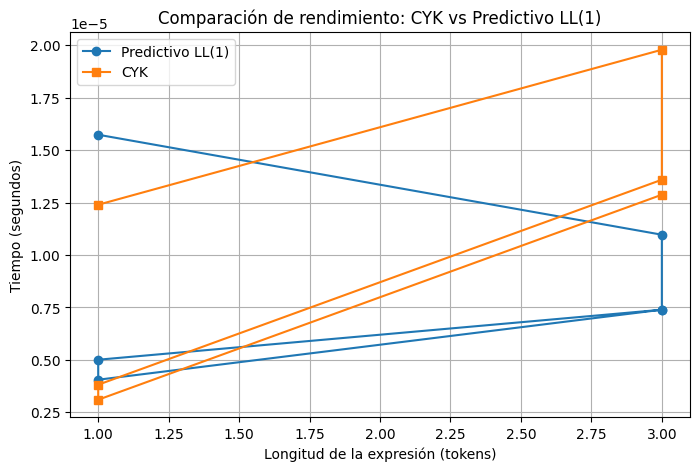

In [ ]:
# =====================================
#  Comparación CYK vs Parser Predictivo (LL(1))
# =====================================
import time, random, pandas as pd, matplotlib.pyplot as plt

# -------------------------------
# 1️ Gramática LL(1) para expresiones aritméticas
#    E → T E'
#    E' → + T E' | ε
#    T → F T'
#    T' → * F T' | ε
#    F → ( E ) | id
# -------------------------------
grammar = {
    "E": [["T", "E'"]],
    "E'": [["+", "T", "E'"], ["ε"]],
    "T": [["F", "T'"]],
    "T'": [["*", "F", "T'"], ["ε"]],
    "F": [["(", "E", ")"], ["id"]],
}

terminals = ["id", "+", "*", "(", ")"]

# -------------------------------
# 2️ Generador de expresiones válidas (para probar)
# -------------------------------
def generate_expression(depth=0):
    if depth > 3:
        return "id"
    choice = random.choice(["sum", "mul", "par", "id"])
    if choice == "id":
        return "id"
    elif choice == "sum":
        return f"{generate_expression(depth+1)} + {generate_expression(depth+1)}"
    elif choice == "mul":
        return f"{generate_expression(depth+1)} * {generate_expression(depth+1)}"
    else:
        return f"( {generate_expression(depth+1)} )"

# -------------------------------
# 3️ Parser Predictivo LL(1)
# -------------------------------
parse_table = {
    ("E", "id"): ["T", "E'"],
    ("E", "("): ["T", "E'"],
    ("E'", "+"): ["+", "T", "E'"],
    ("E'", ")"): ["ε"],
    ("E'", "$"): ["ε"],
    ("T", "id"): ["F", "T'"],
    ("T", "("): ["F", "T'"],
    ("T'", "+"): ["ε"],
    ("T'", "*"): ["*", "F", "T'"],
    ("T'", ")"): ["ε"],
    ("T'", "$"): ["ε"],
    ("F", "id"): ["id"],
    ("F", "("): ["(", "E", ")"]
}

def predictive_parse(tokens):
    stack = ["$", "E"]
    tokens.append("$")
    i = 0
    while stack:
        top = stack.pop()
        current = tokens[i]
        if top in terminals or top == "$":
            if top == current:
                i += 1
            else:
                return False
        elif top == "ε":
            continue
        else:
            rule = parse_table.get((top, current))
            if not rule:
                return False
            for symbol in reversed(rule):
                if symbol != "ε":
                    stack.append(symbol)
        if top == "$" and current == "$":
            return True
    return i == len(tokens)

# -------------------------------
# 4️ CYK Parser (gramática en CNF)
# -------------------------------
cnf = {
    "E": [["T", "E'"]],
    "E'": [["+", "T"], ["ε"]],
    "T": [["F", "T'"]],
    "T'": [["*", "F"], ["ε"]],
    "F": [["(", "E"], ["id"]],
}

def cyk_parse(tokens):
    n = len(tokens)
    if n == 0: return False
    table = [[set() for _ in range(n)] for _ in range(n)]

    # Inicializar con reglas terminales
    for i, token in enumerate(tokens):
        for var, prods in cnf.items():
            for prod in prods:
                if len(prod) == 1 and prod[0] == token:
                    table[i][i].add(var)

    # Llenado del resto
    for l in range(2, n+1):
        for i in range(n-l+1):
            j = i+l-1
            for k in range(i, j):
                for var, prods in cnf.items():
                    for prod in prods:
                        if len(prod) == 2:
                            A, B = prod
                            if A in table[i][k] and B in table[k+1][j]:
                                table[i][j].add(var)
    return "E" in table[0][n-1]

# -------------------------------
# 5️ Pruebas y comparación de tiempos
# -------------------------------
sizes = [5, 10, 20, 40, 80, 160]
results = []

for n in sizes:
    expr = generate_expression(depth=3)
    tokens = expr.replace("(", "( ").replace(")", " )").split()

    # LL(1)
    start = time.time()
    pred_ok = predictive_parse(tokens.copy())
    pred_time = time.time() - start

    # CYK
    start = time.time()
    cyk_ok = cyk_parse(tokens.copy())
    cyk_time = time.time() - start

    results.append({
        "Length": len(tokens),
        "Predictive_Time": pred_time,
        "CYK_Time": cyk_time,
        "Predictive_OK": pred_ok,
        "CYK_OK": cyk_ok
    })

df = pd.DataFrame(results)
print("📊 Comparación de rendimiento:")
print(df)

# -------------------------------
# 6️ Gráfico comparativo
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(df["Length"], df["Predictive_Time"], marker="o", label="Predictivo LL(1)")
plt.plot(df["Length"], df["CYK_Time"], marker="s", label="CYK")
plt.xlabel("Longitud de la expresión (tokens)")
plt.ylabel("Tiempo (segundos)")
plt.title("Comparación de rendimiento: CYK vs Predictivo LL(1)")
plt.legend()
plt.grid(True)
plt.show()


Punto 5

In [ ]:
# =====================================
#  Punto 5: Algoritmo de emparejamiento para parser descendente recursivo
# =====================================

# Gramática:
#   E → T E'
#   E' → + T E' | ε
#   T → F T'
#   T' → * F T' | ε
#   F → ( E ) | id
# =====================================

# --- 1️ Analizador léxico ---
# Convierte una cadena de entrada (expresión) en una lista de tokens válidos
# Ejemplo: "id + id * id" → ["id", "+", "id", "*", "id", "$"]
def tokenize(expr):
    tokens = []
    i = 0
    while i < len(expr):
        if expr[i].isspace():
            # Ignora espacios en blanco
            i += 1
        elif expr[i] in ['+', '*', '(', ')']:
            # Reconoce operadores y paréntesis
            tokens.append(expr[i])
            i += 1
        elif expr[i:i+2] == "id":
            # Reconoce identificadores "id"
            tokens.append("id")
            i += 2
        else:
            # Si aparece un símbolo desconocido, lanza error
            raise ValueError(f"Token inválido en posición {i}: '{expr[i]}'")
    tokens.append("$")  # Marca fin de entrada
    return tokens


# --- 2️ Parser Descendente Recursivo ---
# Implementa un analizador recursivo que sigue directamente la gramática.
# Cada método corresponde a una regla no terminal (E, E’, T, T’, F).
class RecursiveDescentParser:
    def __init__(self, tokens):
        self.tokens = tokens
        self.pos = 0  # Índice del token actual

    def current(self):
        # Retorna el token actual
        return self.tokens[self.pos]

    def match(self, expected):
        """Empareja el token actual con el esperado"""
        if self.current() == expected:
            print(f"✔ Match: {expected}")  # Indica coincidencia correcta
            self.pos += 1  # Avanza al siguiente token
        else:
            # Si el token no coincide, lanza un error sintáctico
            raise SyntaxError(f" Error de emparejamiento: se esperaba '{expected}', encontrado '{self.current()}'")

    # --- Reglas de la gramática ---

    def E(self):
        # Regla E → T E'
        print("→ E")
        self.T()
        self.Ep()

    def Ep(self):
        # Regla E' → + T E' | ε
        print("→ E'")
        if self.current() == "+":
            # Si hay un '+', consume y continúa
            self.match("+")
            self.T()
            self.Ep()
        else:
            # Si no hay '+', aplica la producción vacía (ε)
            print("ε (E')")  # epsilon, no hace nada

    def T(self):
        # Regla T → F T'
        print("→ T")
        self.F()
        self.Tp()

    def Tp(self):
        # Regla T' → * F T' | ε
        print("→ T'")
        if self.current() == "*":
            # Si hay un '*', consume y continúa
            self.match("*")
            self.F()
            self.Tp()
        else:
            # Si no hay '*', aplica la producción vacía
            print("ε (T')")

    def F(self):
        # Regla F → ( E ) | id
        print("→ F")
        if self.current() == "id":
            # Caso 1: identificador
            self.match("id")
        elif self.current() == "(":
            # Caso 2: expresión entre paréntesis
            self.match("(")
            self.E()
            self.match(")")
        else:
            # Si no se cumple ninguna, hay error
            raise SyntaxError(f" Error en F: se esperaba 'id' o '(', encontrado '{self.current()}'")

    def parse(self):
        # Inicia el análisis desde el símbolo inicial E
        self.E()
        # Si al final queda solo el símbolo de fin ($), la expresión es válida
        if self.current() == "$":
            print("\n Expresión válida")
            return True
        else:
            # Si quedan tokens sin analizar, hay error
            print("\n Tokens restantes sin analizar:", self.tokens[self.pos:])
            return False


# --- 3️ Pruebas de funcionamiento ---
# Se prueban varias expresiones para verificar el funcionamiento
examples = [
    "id + id * id",    # Válida
    "( id + id ) * id",# Válida
    "id + * id",       # Inválida (error de orden)
    "( id + id"        # Inválida (falta cierre de paréntesis)
]

for expr in examples:
    print("\n===============================")
    print(f"Expresión: {expr}")
    try:
        # 1️ Tokenización
        tokens = tokenize(expr)
        # 2️ Creación del parser
        parser = RecursiveDescentParser(tokens)
        # 3️ Análisis sintáctico
        parser.parse()
    except Exception as e:
        # Captura y muestra cualquier error
        print("Error:", e)



Expresión: id + id * id
→ E
→ T
→ F
✔ Match: id
→ T'
ε (T')
→ E'
✔ Match: +
→ T
→ F
✔ Match: id
→ T'
✔ Match: *
→ F
✔ Match: id
→ T'
ε (T')
→ E'
ε (E')

 Expresión válida

Expresión: ( id + id ) * id
→ E
→ T
→ F
✔ Match: (
→ E
→ T
→ F
✔ Match: id
→ T'
ε (T')
→ E'
✔ Match: +
→ T
→ F
✔ Match: id
→ T'
ε (T')
→ E'
ε (E')
✔ Match: )
→ T'
✔ Match: *
→ F
✔ Match: id
→ T'
ε (T')
→ E'
ε (E')

 Expresión válida

Expresión: id + * id
→ E
→ T
→ F
✔ Match: id
→ T'
ε (T')
→ E'
✔ Match: +
→ T
→ F
Error:  Error en F: se esperaba 'id' o '(', encontrado '*'

Expresión: ( id + id
→ E
→ T
→ F
✔ Match: (
→ E
→ T
→ F
✔ Match: id
→ T'
ε (T')
→ E'
✔ Match: +
→ T
→ F
✔ Match: id
→ T'
ε (T')
→ E'
ε (E')
Error:  Error de emparejamiento: se esperaba ')', encontrado '$'
